# Retail Market Segmentation
## Introduction
Correctly segmented customers can help a bussiness a lot. By segmenting them, a bussiness can take measures to maximize their profit. For example, giving small coupouns for a customer who order a lot would encourage them to order more. This project aims to do customer segmentation for a retail's customers. The algorithm used here is KMeans, a popular clustering algorithm.
## Getting the Data
This dataset contains transactional data occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail which sells gifts. The data is obtained in http://archive.ics.uci.edu/ml/datasets/online+retail.

In [132]:
# !mkdir data

In [161]:
# # Download the data
# import urllib.request

# # Download from UCI
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
# urllib.request.urlretrieve(url, 'data/online_retail.xlsx')

In [134]:
import pandas as pd
df = pd.read_excel('data/online_retail.xlsx')

In [167]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Getting to know the data

In [168]:
# Get type of each variables
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [169]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


What's up with negative values in `Quantity` and `UnitPrice`? We will go back to this later.

In [170]:
# see data size
df.shape

(541909, 8)

In [171]:
# see missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [172]:
# The portion of missing ID
df.loc[df['CustomerID'].isnull()].shape[0]/df.shape[0]

0.249266943342886

In [173]:
# records with negative quantity
df.loc[df['Quantity'] <= 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [174]:
# records with negative UnitPrice
df.loc[df['UnitPrice'] <= 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


**Findings**
- it looks like the data has a LOT of missing ID (about 25%).
- data has negative Quantity and UnitPrice

We will clean it later.



## Cleaning the data
We will remove:

- records with no ID
- records with Quantity <= 0 (no sell)
- records with Price <= 0


In [175]:
# remove those with missing ID
df_clean = df.loc[df['CustomerID'].notna()]

# only take records with positive Quantity
df_clean = df_clean.loc[df_clean['Quantity'] > 0]

# only take records with positive UnitPrice
df_clean = df_clean.loc[df_clean['UnitPrice'] > 0]

In [176]:
(df_clean['Country'].value_counts(normalize=True) * 100)[:5]

United Kingdom    89.051332
Germany            2.272019
France             2.096340
EIRE               1.818621
Spain              0.624303
Name: Country, dtype: float64

**Findings**

- a big portion (88%) customer are in the UK. 

We will remove those who are not from the UK in order to make our clusters have the same demographic

In [177]:
df_clean = df_clean.loc[df_clean['Country'] == 'United Kingdom']

### A little bit of preprocessing

We create new column `TotalSales` = `Quantity` x `UnitPrice`. 

Next, let's see how each customer spent their money. We will group each customerID and see how much that ID spent and how many transactions belong to that ID. The latter can be obtained by counting the number of unique invoice belong to that particular ID.

In [178]:
df_clean['TotalSales'] = df_clean['Quantity'] * df_clean['UnitPrice']

In [179]:
customer_df = df_clean.groupby('CustomerID').agg({'TotalSales':sum,
                                                  'InvoiceNo': lambda x: x.nunique()})

customer_df.columns = ['TotalSales', 'OrderCount']

customer_df['AvgOrderValue'] = customer_df['TotalSales']/customer_df['OrderCount']

customer_df

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12747.0,4196.01,11,381.455455
12748.0,33719.73,209,161.338421
12749.0,4090.88,5,818.176000
12820.0,942.34,4,235.585000
...,...,...,...
18280.0,180.60,1,180.600000
18281.0,80.82,1,80.820000
18282.0,178.05,2,89.025000


In [180]:
customer_df.rank

<bound method NDFrame.rank of             TotalSales  OrderCount  AvgOrderValue
CustomerID                                       
12346.0       77183.60           1   77183.600000
12747.0        4196.01          11     381.455455
12748.0       33719.73         209     161.338421
12749.0        4090.88           5     818.176000
12820.0         942.34           4     235.585000
...                ...         ...            ...
18280.0         180.60           1     180.600000
18281.0          80.82           1      80.820000
18282.0         178.05           2      89.025000
18283.0        2094.88          16     130.930000
18287.0        1837.28           3     612.426667

[3920 rows x 3 columns]>

**Normalizing**

In [181]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

In [182]:
rank_df = customer_df.rank(method='first')
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.726970,-1.731388,1.730505
12747.0,1.481333,1.459243,0.734702
12748.0,1.711066,1.731388,-0.990059
12749.0,1.468079,0.842500,1.558205
12820.0,0.397172,0.531477,-0.299978
12821.0,-1.620940,-1.730505,-1.537883
12822.0,0.403357,-0.538546,1.113761
12823.0,0.949414,0.843384,0.551800
12824.0,-0.502319,-1.729621,0.807156


In [183]:
normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']]

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.726970,-1.731388,1.730505
12747.0,1.481333,1.459243,0.734702
12748.0,1.711066,1.731388,-0.990059
12749.0,1.468079,0.842500,1.558205
12820.0,0.397172,0.531477,-0.299978
...,...,...,...
18280.0,-1.262204,-0.540313,-0.804506
18281.0,-1.643029,-0.539430,-1.587364
18282.0,-1.276341,0.119726,-1.560856


## Clustering
The algorithm will be used here is KMeans. We will try to find the best `k` first, by silhouette score and elbow method.
### Silhouette score

In [184]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

k_range = list(range(2, 11))
for k in k_range:
    kmeans = KMeans(n_clusters=k).fit(normalized_df)
    
    silhouette_avg = silhouette_score(normalized_df, kmeans.labels_)
    
    print(f'Silhouette Score for {k}: {silhouette_avg}')

Silhouette Score for 2: 0.43229469581403757
Silhouette Score for 3: 0.41609706264177443
Silhouette Score for 4: 0.41526105413384357
Silhouette Score for 5: 0.3823202267077402
Silhouette Score for 6: 0.3798715597007363
Silhouette Score for 7: 0.3908584370824903
Silhouette Score for 8: 0.3801291049044257
Silhouette Score for 9: 0.3768634343617502
Silhouette Score for 10: 0.3776792057677794


### Elbow method

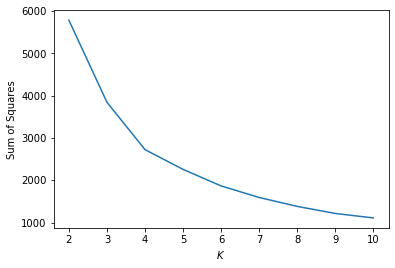

In [185]:
import numpy as np
import matplotlib.pyplot as plt

sse = []
X = normalized_df.values
for k in k_range:
    model = KMeans(n_clusters=k, random_state=3)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    sse.append(np.sum((X - centers[cluster_assignments]) ** 2))

plt.plot(k_range, sse)
plt.xlabel('$K$')
plt.ylabel('Sum of Squares')
plt.show()

In [186]:
for k, err in enumerate(sse):
    print(f'SSE for when k={k_range[k]}: {err}')

SSE for when k=2: 5783.902607621294
SSE for when k=3: 3844.204953565035
SSE for when k=4: 2725.6868024073137
SSE for when k=5: 2258.6092413580022
SSE for when k=6: 1867.9303521502347
SSE for when k=7: 1594.6106052077125
SSE for when k=8: 1383.818462756771
SSE for when k=9: 1216.8299189259865
SSE for when k=10: 1111.4060830826038


Based on Silhouette score and Elbow method, looks like `k=4` is the best one.

In [200]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(normalized_df)

four_cluster_df = normalized_df.copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_

four_cluster_df.head(10)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.726970,-1.731388,1.730505,3
12747.0,1.481333,1.459243,0.734702,0
12748.0,1.711066,1.731388,-0.990059,2
12749.0,1.468079,0.842500,1.558205,0
12820.0,0.397172,0.531477,-0.299978,2
12821.0,-1.620940,-1.730505,-1.537883,1
12822.0,0.403357,-0.538546,1.113761,3
12823.0,0.949414,0.843384,0.551800,0
12824.0,-0.502319,-1.729621,0.807156,3


## Plot, Findings and Feebacks

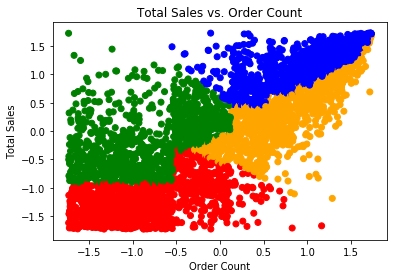

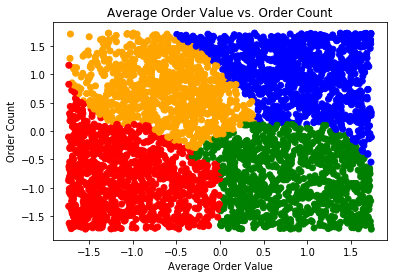

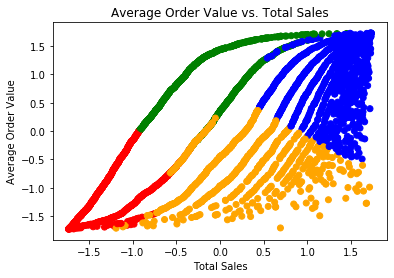

In [201]:
colors_map = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green' }
labels=four_cluster_df['Cluster'].values
colors_label = [colors_map[l] for l in labels]


plt.scatter(four_cluster_df['OrderCount'].values, four_cluster_df['TotalSales'].values, c=colors_label)
plt.xlabel('Order Count')
plt.ylabel('Total Sales')
plt.title('Total Sales vs. Order Count')
plt.show()

plt.scatter(four_cluster_df['AvgOrderValue'].values, four_cluster_df['OrderCount'].values, c=colors_label)
plt.xlabel('Average Order Value')
plt.ylabel('Order Count')
plt.title('Average Order Value vs. Order Count')
plt.show()

plt.scatter(four_cluster_df['TotalSales'].values, four_cluster_df['AvgOrderValue'].values, c=colors_label)
plt.xlabel('Total Sales')
plt.ylabel('Average Order Value')
plt.title('Average Order Value vs. Total Sales')
plt.show()

**Findings**
- 'blue' cluster is highest-value cluster. They spent the most and order the most. They are the customers the retail should keep by any means.
- 'red' is the lowest-valued costumer. They spent the least and order the least. They are the kind of customers who bough once in a while.

**Feedbacks**

In terms of growth, I would focus on the greens and the yellows. For example, maybe try to improve order count of greens by encouraging them to order more. Green cluster did not order much, but when they did, they bought expensive items. I would try giving them coupon to high-valued items.

On the other side, yellow cluster ordered a lot of time, but they dit it for cheap items. I would try giving them recommendations for each items they bought in the hope that they will buy more items. Ideally, of course, yellows should be converted to blues as they are the highest-valued customer.

As for the reds, they are the ones the shop should try to move to another cluster. The reds had the same amount of customer as the blues and this is a problem. The shop should try to move red customer to greens or yellow, whichever the closest.
